## Imports 

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3
from datetime import timedelta
import seaborn as sns
from global_land_mask import globe
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import torch
import pytorch_lightning as pl

2022-11-16 05:12:15.956124: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

## Data preparation

In [5]:
filelist = []
for file in os.listdir("./data/"):
    if file.endswith(".txt"):
        filelist.append(file)
        
        
data = pd.DataFrame()
for i in filelist:
    data_sub=pd.read_csv('data/'+i, sep=' ', header=None)
    data_sub["car"] = i.split(".")[0].split("_")[-1]
    data_sub.columns = ["latitude", "longitude", "occupancy", "time","car"]
    data_sub["prev_occ"] = data_sub["occupancy"].shift(1).fillna(0).astype(int)
    data_sub["time_detail"] = pd.to_datetime(data_sub["time"], unit='s')
    data_sub["time_detail"] = data_sub["time_detail"]- timedelta(hours=7)
    data_sub = data_sub[(data_sub["prev_occ"] == 0) & (data_sub["occupancy"] == 1)]
    data = pd.concat([data, data_sub])

In [6]:
# Small map configuration
bounds = [-122.527210,  37.705002, -122.357608,  37.839607]
bounds

[-122.52721, 37.705002, -122.357608, 37.839607]

In [7]:
out_ns = (data.latitude < bounds[1]) | (data.latitude > bounds[3])
out_we = (data.longitude < bounds[0]) | (data.longitude > bounds[2])
outside = out_ns | out_we

In [8]:
data = data[~outside].copy()

In [9]:
# Only take data in the land
is_on_land = globe.is_land(data["latitude"], data["longitude"])

In [10]:
data = data[is_on_land].copy()

In [11]:
data

,latitude,longitude,occupancy,time,car,prev_occ,time_detail
14,37.74977,-122.39724,1,1211035870,abboip,0,2008-05-17 07:51:10
42,37.75053,-122.42086,1,1211037486,abboip,0,2008-05-17 08:18:06
72,37.77173,-122.41838,1,1211039031,abboip,0,2008-05-17 08:43:51
76,37.77181,-122.41833,1,1211039168,abboip,0,2008-05-17 08:46:08
114,37.75240,-122.41842,1,1211041120,abboip,0,2008-05-17 09:18:40
...,...,...,...,...,...,...,...
22156,37.80299,-122.42317,1,1213024769,uvreoipy,0,2008-06-09 08:19:29
22184,37.79697,-122.43550,1,1213026399,uvreoipy,0,2008-06-09 08:46:39
22240,37.75607,-122.43609,1,1213034191,uvreoipy,0,2008-06-09 10:56:31
22250,37.75902,-122.44068,1,1213034779,uvreoipy,0,2008-06-09 11:06:19


In [12]:
# Binning location by h3 codes 
data['pickup_h3'] = [h3.geo_to_h3(lat, long, 8) for lat, long in zip(data["latitude"], data["longitude"])]

In [13]:
# Binning times in 15-min frequency
data["demand_time"] = data["time_detail"].dt.floor(freq="15min")

In [14]:
# Remove unconsistency day intervals
data = data[(data["demand_time"] >= "2008-05-18 00:00:00")&(data["demand_time"]<"2008-06-08 00:00:00")].sort_values(by=["demand_time","pickup_h3"]).reset_index()
data

,index,latitude,longitude,occupancy,time,car,prev_occ,time_detail,pickup_h3,demand_time
0,1014,37.79856,-122.40106,1,1211094488,ibpijda,0,2008-05-18 00:08:08,88283080c9fffff,2008-05-18 00:00:00
1,1008,37.80835,-122.41011,1,1211094187,eegcef,0,2008-05-18 00:03:07,88283080cbfffff,2008-05-18 00:00:00
2,791,37.80831,-122.41060,1,1211094516,iatmeuns,0,2008-05-18 00:08:36,88283080cbfffff,2008-05-18 00:00:00
3,1079,37.80657,-122.42078,1,1211094588,obceoo,0,2008-05-18 00:09:48,88283080d9fffff,2008-05-18 00:00:00
4,1184,37.80861,-122.41223,1,1211094256,ewufri,0,2008-05-18 00:04:16,88283080ddfffff,2008-05-18 00:00:00
...,...,...,...,...,...,...,...,...,...,...
387347,20799,37.78010,-122.48409,1,1212908356,efghakdi,0,2008-06-07 23:59:16,88283095b5fffff,2008-06-07 23:45:00
387348,25722,37.78032,-122.47794,1,1212907871,okquakar,0,2008-06-07 23:51:11,88283095b5fffff,2008-06-07 23:45:00
387349,23262,37.78002,-122.48451,1,1212907639,ujkiwe,0,2008-06-07 23:47:19,88283095b5fffff,2008-06-07 23:45:00
387350,17588,37.75081,-122.47608,1,1212907985,itmeps,0,2008-06-07 23:53:05,88283095e3fffff,2008-06-07 23:45:00


In [15]:
df_hex_group = data.groupby(["demand_time","pickup_h3"]).count()["time_detail"].reset_index()
df_hex_group.columns = ["demand_time","pickup_h3","pickup_count"]
df_hex_group

,demand_time,pickup_h3,pickup_count
0,2008-05-18 00:00:00,88283080c9fffff,1
1,2008-05-18 00:00:00,88283080cbfffff,2
2,2008-05-18 00:00:00,88283080d9fffff,1
3,2008-05-18 00:00:00,88283080ddfffff,1
4,2008-05-18 00:00:00,8828308253fffff,1
...,...,...,...
95350,2008-06-07 23:45:00,88283095abfffff,1
95351,2008-06-07 23:45:00,88283095adfffff,2
95352,2008-06-07 23:45:00,88283095b5fffff,3
95353,2008-06-07 23:45:00,88283095e3fffff,1


In [17]:
df_hex_group_piv = df_hex_group.pivot(index="demand_time", columns="pickup_h3", values="pickup_count").fillna(0).reset_index()
df_hex_group_piv

pickup_h3,demand_time,8828308011fffff,8828308017fffff,882830803bfffff,88283080c1fffff,88283080c9fffff,88283080cbfffff,88283080cdfffff,88283080d9fffff,88283080ddfffff,...,88283095d5fffff,88283095d7fffff,88283095ddfffff,88283095e1fffff,88283095e3fffff,88283095e5fffff,88283095e7fffff,88283095e9fffff,88283095ebfffff,88283095edfffff
0,2008-05-18 00:00:00,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2008-05-18 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2008-05-18 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2008-05-18 00:45:00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2008-05-18 01:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,2008-06-07 22:45:00,0.0,0.0,0.0,0.0,3.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004,2008-06-07 23:00:00,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005,2008-06-07 23:15:00,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006,2008-06-07 23:30:00,0.0,0.0,0.0,0.0,3.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
# Missing pickup data time intervals
missing_times = ["2008-05-20 07:15:00","2008-05-20 07:30:00","2008-05-20 07:45:00","2008-05-20 08:00:00","2008-05-20 08:15:00", "2008-05-21 11:30:00", "2008-05-21 11:45:00", "2008-05-21 12:00:00"]

In [19]:
# Additional data subset with NaNs
feature_list = df_hex_group_piv.columns.tolist()
zero_data = np.zeros(shape=(len(missing_times),len(feature_list)))
new2 = pd.DataFrame(zero_data, columns=feature_list).set_index("demand_time")
new2.loc[:] = np.nan
new2 = new2.reset_index()
new2["demand_time"] = pd.to_datetime(missing_times)

In [20]:
df_hex_group_piv = pd.concat([df_hex_group_piv, new2]).sort_values(by="demand_time").reset_index(drop=True)
df_hex_group_piv

,demand_time,8828308011fffff,8828308017fffff,882830803bfffff,88283080c1fffff,88283080c9fffff,88283080cbfffff,88283080cdfffff,88283080d9fffff,88283080ddfffff,...,88283095d5fffff,88283095d7fffff,88283095ddfffff,88283095e1fffff,88283095e3fffff,88283095e5fffff,88283095e7fffff,88283095e9fffff,88283095ebfffff,88283095edfffff
0,2008-05-18 00:00:00,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2008-05-18 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2008-05-18 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2008-05-18 00:45:00,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,2008-05-18 01:00:00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2008-06-07 22:45:00,0.0,0.0,0.0,0.0,3.0,4.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012,2008-06-07 23:00:00,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,2008-06-07 23:15:00,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014,2008-06-07 23:30:00,0.0,0.0,0.0,0.0,3.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [21]:
# Prepare dataframe for interpolation
df_hex_melted = pd.melt(df_hex_group_piv, id_vars=df_hex_group_piv.columns.tolist()[0], value_vars=df_hex_group_piv.columns.tolist()[1:])
df_hex_melted.columns = ["demand_time","pickup_h3","pickup_count"]
df_hex_melted = df_hex_melted.sort_values(by=["pickup_h3","demand_time"])
df_hex_melted

,demand_time,pickup_h3,pickup_count
0,2008-05-18 00:00:00,8828308011fffff,0.0
1,2008-05-18 00:15:00,8828308011fffff,0.0
2,2008-05-18 00:30:00,8828308011fffff,0.0
3,2008-05-18 00:45:00,8828308011fffff,0.0
4,2008-05-18 01:00:00,8828308011fffff,0.0
...,...,...,...
372955,2008-06-07 22:45:00,88283095edfffff,0.0
372956,2008-06-07 23:00:00,88283095edfffff,0.0
372957,2008-06-07 23:15:00,88283095edfffff,0.0
372958,2008-06-07 23:30:00,88283095edfffff,1.0


In [22]:
df_hex_melted.isnull().sum()

demand_time        0
pickup_h3          0
pickup_count    1480
dtype: int64

In [23]:
# Fill NaN values with interpolation
df_hex_melted = df_hex_melted.interpolate()

In [24]:
df_hex_melted.isnull().sum()

demand_time     0
pickup_h3       0
pickup_count    0
dtype: int64

In [25]:
data = df_hex_melted.copy()

## Additional Features

In [26]:
data["date"] = data["demand_time"].dt.date
data["hour"] = data["demand_time"].dt.hour
#data["weekday"] = data["demand_time"].dt.dayofweek
data["weekday"] = data["demand_time"].dt.day_name()

In [27]:
# addition of time indices
data["time_idx"] = data["demand_time"].dt.month * 31 * 24 * 4 + data["demand_time"].dt.day * 24 * 4 + data["demand_time"].dt.hour* 4  + (data["demand_time"].dt.minute/15).astype(int)
data["time_idx"] -= data["time_idx"].min()

In [28]:
data

,demand_time,pickup_h3,pickup_count,date,hour,weekday,time_idx
0,2008-05-18 00:00:00,8828308011fffff,0.0,2008-05-18,0,Sunday,0
1,2008-05-18 00:15:00,8828308011fffff,0.0,2008-05-18,0,Sunday,1
2,2008-05-18 00:30:00,8828308011fffff,0.0,2008-05-18,0,Sunday,2
3,2008-05-18 00:45:00,8828308011fffff,0.0,2008-05-18,0,Sunday,3
4,2008-05-18 01:00:00,8828308011fffff,0.0,2008-05-18,1,Sunday,4
...,...,...,...,...,...,...,...
372955,2008-06-07 22:45:00,88283095edfffff,0.0,2008-06-07,22,Saturday,2011
372956,2008-06-07 23:00:00,88283095edfffff,0.0,2008-06-07,23,Saturday,2012
372957,2008-06-07 23:15:00,88283095edfffff,0.0,2008-06-07,23,Saturday,2013
372958,2008-06-07 23:30:00,88283095edfffff,1.0,2008-06-07,23,Saturday,2014


In [29]:
data["day_of_week"] = data.demand_time.dt.dayofweek.astype(str).astype("category") 

In [30]:
data["week_of_year"] = data.demand_time.dt.weekofyear.astype(str).astype("category") 

In [31]:
data["month"] = data.demand_time.dt.month.astype(str).astype("category")

In [32]:
data["hour_cat"] = data.demand_time.dt.hour.astype(str).astype("category")

In [33]:
data.groupby(["time_idx", "hour"], observed=True).pickup_count.transform("mean")

0         2.345946
1         2.335135
2         2.475676
3         2.302703
4         2.102703
            ...   
372955    2.297297
372956    2.318919
372957    2.443243
372958    2.372973
372959    2.513514
Name: pickup_count, Length: 372960, dtype: float64

In [34]:
# Checking for test dataset boundary
#data2[(data2["demand_time"] >= "2008-06-07 00:00:00")]

In [35]:
# Checking for test dataset boundary
#data2 = data.sort_values(by="demand_time").reset_index(drop=True)
#data = data.sort_values(by="demand_time").reset_index(drop=True)

## Model and training

In [36]:
# For creating test data set 
#train = data.iloc[:372960]
#test = data.iloc[372960:]

max_prediction_length = 4*7 # 7 hours-long
max_encoder_length = 4*24*7 # 1 week-long
training_cutoff = data["time_idx"].max() - max_prediction_length

In [37]:
data

,demand_time,pickup_h3,pickup_count,date,hour,weekday,time_idx,day_of_week,week_of_year,month,hour_cat
0,2008-05-18 00:00:00,8828308011fffff,0.0,2008-05-18,0,Sunday,0,6,20,5,0
1,2008-05-18 00:15:00,8828308011fffff,0.0,2008-05-18,0,Sunday,1,6,20,5,0
2,2008-05-18 00:30:00,8828308011fffff,0.0,2008-05-18,0,Sunday,2,6,20,5,0
3,2008-05-18 00:45:00,8828308011fffff,0.0,2008-05-18,0,Sunday,3,6,20,5,0
4,2008-05-18 01:00:00,8828308011fffff,0.0,2008-05-18,1,Sunday,4,6,20,5,1
...,...,...,...,...,...,...,...,...,...,...,...
372955,2008-06-07 22:45:00,88283095edfffff,0.0,2008-06-07,22,Saturday,2011,5,23,6,22
372956,2008-06-07 23:00:00,88283095edfffff,0.0,2008-06-07,23,Saturday,2012,5,23,6,23
372957,2008-06-07 23:15:00,88283095edfffff,0.0,2008-06-07,23,Saturday,2013,5,23,6,23
372958,2008-06-07 23:30:00,88283095edfffff,1.0,2008-06-07,23,Saturday,2014,5,23,6,23


In [38]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff].drop(['demand_time','date',"hour","weekday"], axis = 1),
    time_idx="time_idx",
    target="pickup_count",
    group_ids=["pickup_h3"],
    min_encoder_length=max_encoder_length, #// 2,  # encoder length experimentation
    max_encoder_length=max_encoder_length,
    #min_prediction_length=1, # prediction length experimentation
    max_prediction_length=max_prediction_length,
    static_categoricals=["pickup_h3"],
    #static_reals=[""],
    time_varying_known_categoricals=["month", "week_of_year", "day_of_week","hour_cat"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["pickup_count"],
    #Target normalizer with log provided low performance in this work
    #softplus and it is normalized by group
    #target_normalizer=GroupNormalizer(groups=["pickup_h3"], transformation="softplus"),
    lags = {"pickup_count": [4, 4*24, 7*4*24 ]}, # 1-hour, 1-day, 1-week lagging
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    #allow_missing_timesteps=True #bypass missing timesteps in the datas set
)

In [39]:
# validation set to predict the last max_prediction_length points for each data series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# dataloaders for training and validation
batch_size = 128  # between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=20)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=20)

In [40]:
# baseline mean absolute error
# i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

1.161776065826416

In [43]:
# training configuarations
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    gpus=1,
    devices=1, accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    #limit_train_batches=100,  # running validation after this number of batches
    #fast_dev_run=True,  # that just check network dataset in terms of bug
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-2,#0.03
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles - this is by default
    loss=QuantileLoss(),
    log_interval=10,  # logging every x batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 26.9k


In [44]:
# training
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 3.2 K 
3  | prescalers                         | ModuleDict                      | 144   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.9 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [45]:
# loading the best model according to the validation loss
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [46]:
# mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.7296)

In [47]:
# raw predictions in dictionary format with quantiles information
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

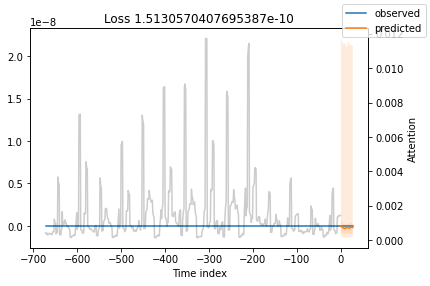

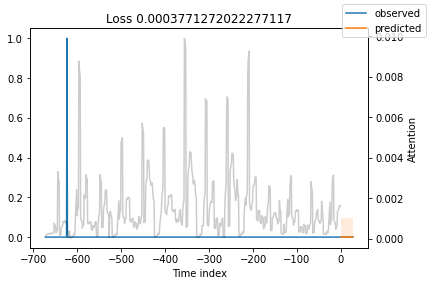

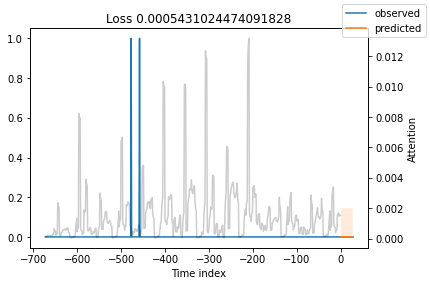

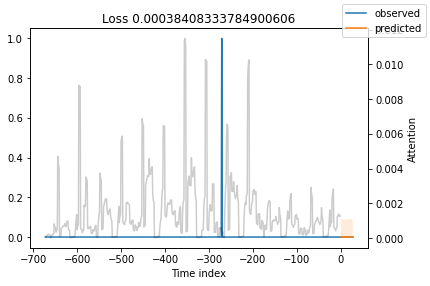

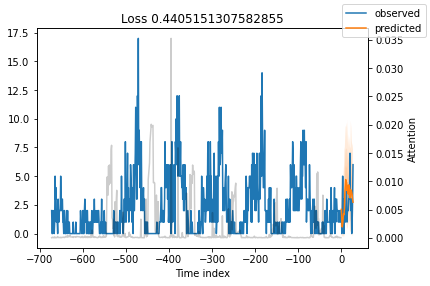

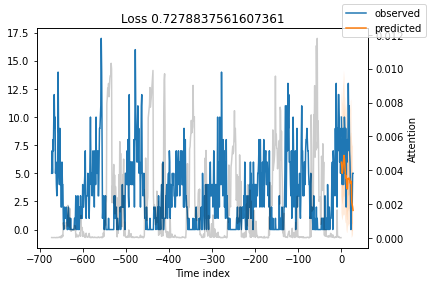

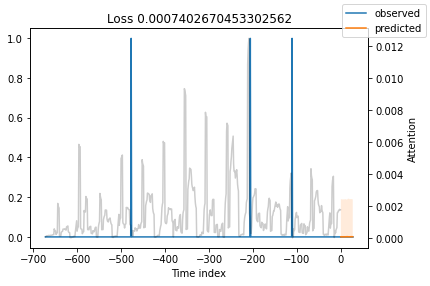

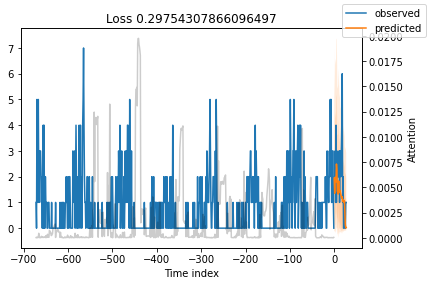

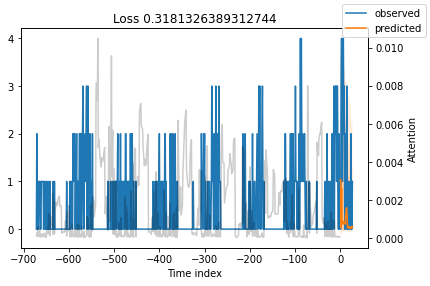

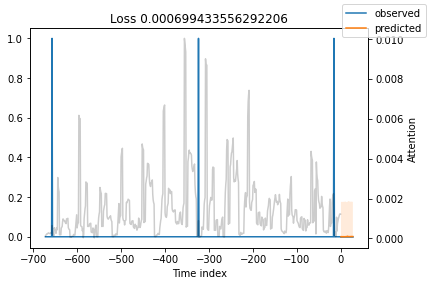

In [49]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

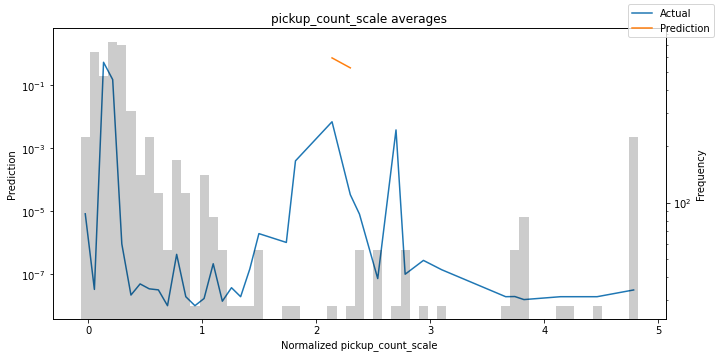

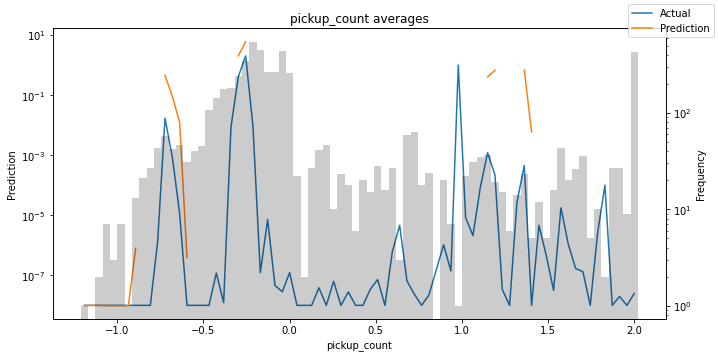

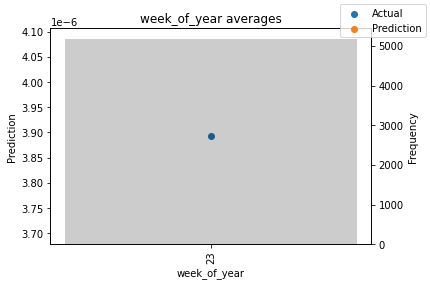

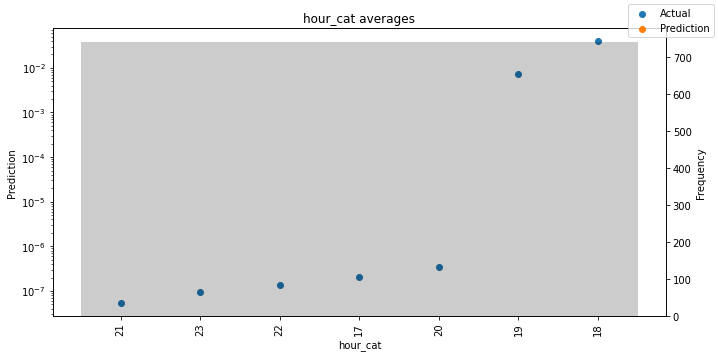

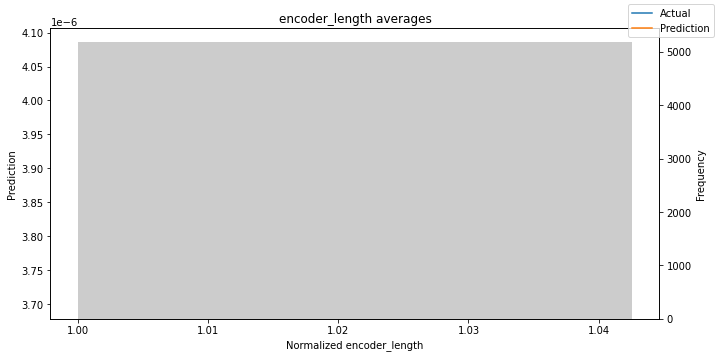

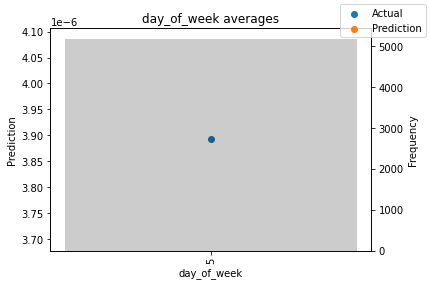

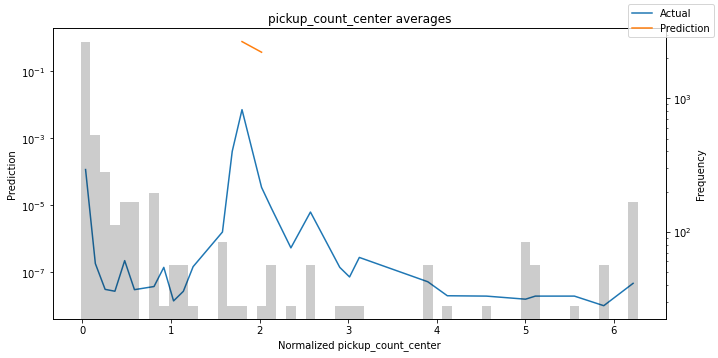

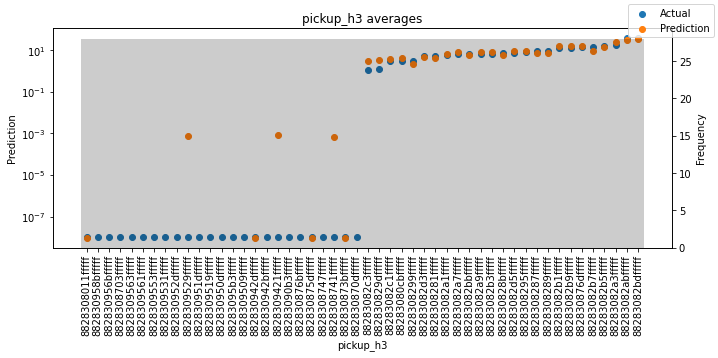

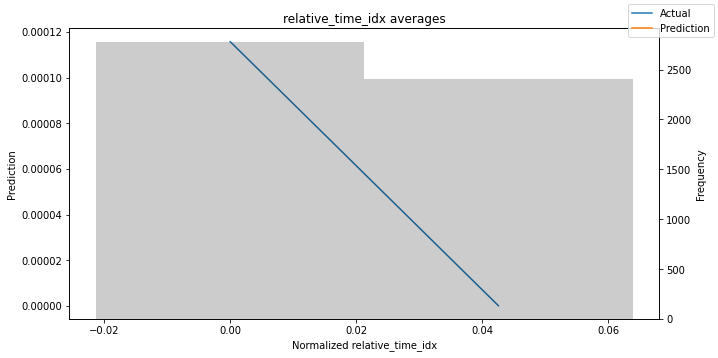

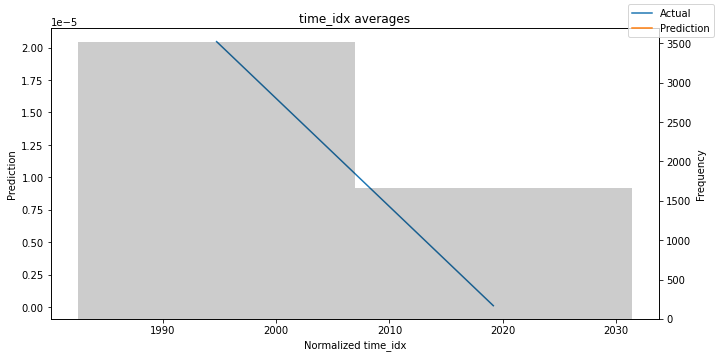

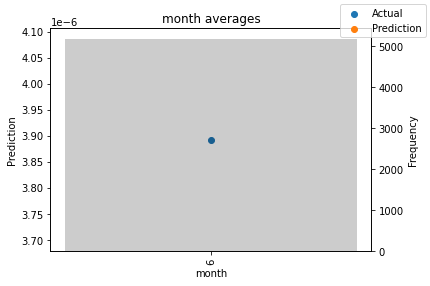

In [50]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
all_features = list(set(predictions_vs_actuals['support'].keys())-set(['pickup_count_lagged_by_96', 'pickup_count_lagged_by_672', 'pickup_count_lagged_by_4']))
for feature in all_features:
    best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name=feature);

In [89]:
#predictions, x = best_tft.predict(val_dataloader, return_x=True)
#predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
#best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [62]:
data

,demand_time,pickup_h3,pickup_count,date,hour,weekday,time_idx
0,2008-05-18 00:00:00,8828308011fffff,0.0,2008-05-18,0,Sunday,0
1,2008-05-18 00:15:00,8828308011fffff,0.0,2008-05-18,0,Sunday,1
2,2008-05-18 00:30:00,8828308011fffff,0.0,2008-05-18,0,Sunday,2
3,2008-05-18 00:45:00,8828308011fffff,0.0,2008-05-18,0,Sunday,3
4,2008-05-18 01:00:00,8828308011fffff,0.0,2008-05-18,1,Sunday,4
...,...,...,...,...,...,...,...
372955,2008-06-07 22:45:00,88283095edfffff,0.0,2008-06-07,22,Saturday,2011
372956,2008-06-07 23:00:00,88283095edfffff,0.0,2008-06-07,23,Saturday,2012
372957,2008-06-07 23:15:00,88283095edfffff,0.0,2008-06-07,23,Saturday,2013
372958,2008-06-07 23:30:00,88283095edfffff,1.0,2008-06-07,23,Saturday,2014


In [63]:
data.sort_values(by="pickup_count")

,demand_time,pickup_h3,pickup_count,date,hour,weekday,time_idx
0,2008-05-18 00:00:00,8828308011fffff,0.0,2008-05-18,0,Sunday,0
241852,2008-06-07 07:00:00,882830951bfffff,0.0,2008-06-07,7,Saturday,1948
241851,2008-06-07 06:45:00,882830951bfffff,0.0,2008-06-07,6,Saturday,1947
241850,2008-06-07 06:30:00,882830951bfffff,0.0,2008-06-07,6,Saturday,1946
241849,2008-06-07 06:15:00,882830951bfffff,0.0,2008-06-07,6,Saturday,1945
...,...,...,...,...,...,...,...
93005,2008-05-20 19:15:00,88283082a3fffff,66.0,2008-05-20,19,Tuesday,269
93867,2008-05-29 18:45:00,88283082a3fffff,67.0,2008-05-29,18,Thursday,1131
93008,2008-05-20 20:00:00,88283082a3fffff,68.0,2008-05-20,20,Tuesday,272
94251,2008-06-02 18:45:00,88283082a3fffff,69.0,2008-06-02,18,Monday,1515


In [51]:
best_tft.predict(
    training.filter(lambda x: (x.pickup_h3 == "88283082a3fffff") & (x.time_idx_first_prediction == 1515)),
    mode="quantiles",
)

tensor([[[45.4051, 51.7175, 56.6572, 63.3081, 67.1387, 71.3388, 78.6937],
         [36.5965, 42.6011, 46.7348, 50.4034, 55.9923, 61.0553, 63.8260],
         [38.0999, 43.7783, 47.5674, 51.6278, 56.8496, 61.0806, 64.9770],
         [33.4289, 38.5975, 41.9258, 45.6899, 50.9136, 54.8583, 58.5483],
         [29.5566, 33.9848, 36.7588, 40.9918, 47.3622, 54.6781, 62.6355],
         [32.4144, 37.2636, 40.5146, 43.7852, 47.9125, 50.9272, 58.4804],
         [34.8524, 39.6409, 42.8181, 46.4030, 50.4846, 53.6533, 63.0141],
         [32.0667, 36.6122, 39.5825, 42.7302, 46.6750, 49.5674, 57.5432],
         [30.1197, 34.4798, 37.2924, 40.2856, 44.0423, 46.7894, 54.3292],
         [30.4800, 34.8661, 37.5911, 41.3308, 46.9683, 52.8819, 58.9827],
         [22.6794, 26.9491, 30.0006, 33.4565, 37.7401, 40.9821, 43.6188],
         [26.4776, 30.3593, 32.9270, 37.0841, 42.7832, 48.5231, 55.2137],
         [22.5837, 26.6137, 29.4276, 32.5051, 37.1954, 41.8974, 45.4330],
         [24.2454, 27.9787, 30.3131, 3

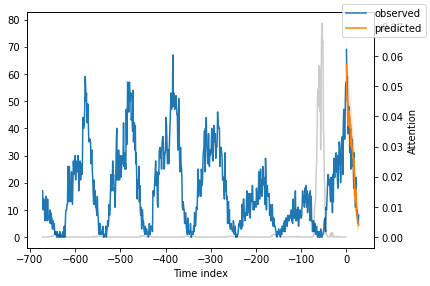

In [52]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.pickup_h3 == "88283082a3fffff") & (x.time_idx_first_prediction == 1515)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x324 with 1 Axes>,
 'decoder_variables': <Figure size 504x288 with 1 Axes>}

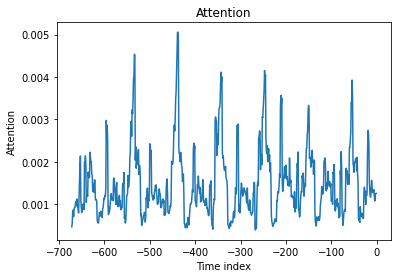

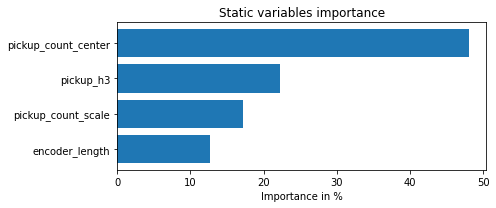

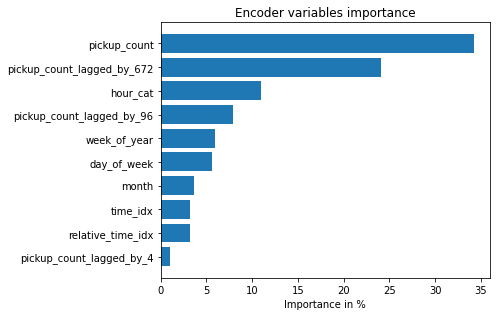

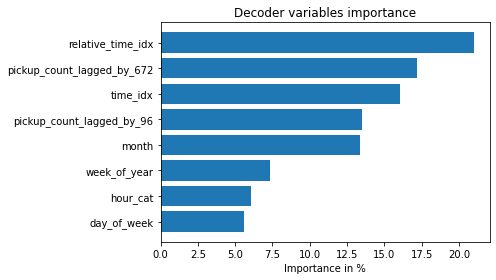

In [53]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)